In [151]:
####################################
#ENVIRONMENT SETUP

In [152]:
#Importing Libraries
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.ticker as ticker
import matplotlib.cm as cm
from matplotlib.colors import Normalize
from matplotlib.ticker import MaxNLocator
from matplotlib.ticker import ScalarFormatter
import matplotlib.gridspec as gridspec
import matplotlib.lines as mlines
import xarray as xr

import sys; import os; import time; from datetime import timedelta
import pickle
import h5py

from tqdm import tqdm

from glob import glob

In [153]:
#MAIN DIRECTORIES
def GetDirectories():
    mainDirectory='/mnt/lustre/koa/koastore/torri_group/air_directory/Projects/DCI-Project/'
    mainCodeDirectory=os.path.join(mainDirectory,"Code/CodeFiles/")
    scratchDirectory='/mnt/lustre/koa/scratch/air673/'
    codeDirectory=os.getcwd()
    return mainDirectory,mainCodeDirectory,scratchDirectory,codeDirectory

[mainDirectory,mainCodeDirectory,scratchDirectory,codeDirectory] = GetDirectories()

In [154]:
def GetPlottingDirectory(plotFileName, plotType):
    plottingDirectory = mainCodeDirectory=os.path.join(mainDirectory,"Code","PLOTTING")
    
    specificPlottingDirectory = os.path.join(plottingDirectory, plotType, 
                                             f"{ModelData.res}_{ModelData.t_res}_{ModelData.Nz_str}nz")
    os.makedirs(specificPlottingDirectory, exist_ok=True)

    plottingFileName=os.path.join(specificPlottingDirectory, plotFileName)

    return plottingFileName

def SaveFigure(fig,plotType, fileName):
    plotFileName = f"{fileName}_{ModelData.res}_{ModelData.t_res}_{ModelData.Np_str}.jpg"
    plottingFileName = GetPlottingDirectory(plotFileName, plotType)
    print(f"Saving figure to {plottingFileName}")
    fig.savefig(plottingFileName, dpi=300, bbox_inches='tight')

In [155]:
#IMPORT CLASSES
sys.path.append(os.path.join(mainCodeDirectory,"2_Variable_Calculation"))
from CLASSES_Variable_Calculation import ModelData_Class, SlurmJobArray_Class, DataManager_Class

In [156]:
#data loading class
ModelData = ModelData_Class(mainDirectory, scratchDirectory, simulationNumber=1)
#data manager class
DataManager = DataManager_Class(mainDirectory, scratchDirectory, ModelData.res, ModelData.t_res, ModelData.Nz_str,
                                ModelData.Np_str, dataType="Tracking_Algorithms", dataName="Lagrangian_UpdraftTracking",
                                dtype='float32',codeSection = "Project_Algorithms")

=== CM1 Data Summary ===
 Simulation #:   1
 Resolution:     1km
 Time step:      5min
 Vertical levels:34
 Parcels:        1e6
 Data file:      /mnt/lustre/koa/koastore/torri_group/air_directory/Projects/DCI-Project/Model/cm1r20.3/run/cm1out_1km_5min_34nz.nc
 Parcel file:    /mnt/lustre/koa/koastore/torri_group/air_directory/Projects/DCI-Project/Model/cm1r20.3/run/cm1out_pdata_1km_5min_1e6np.nc
 Time steps:     133

=== DataManager Summary ===
 inputDirectory #:   /mnt/lustre/koa/koastore/torri_group/air_directory/Projects/DCI-Project/Code/OUTPUT/Variable_Calculation/TimeSplitModelData
 outputDirectory #:   /mnt/lustre/koa/koastore/torri_group/air_directory/Projects/DCI-Project/Code/OUTPUT/Project_Algorithms/Tracking_Algorithms
 inputDataDirectory #:   /mnt/lustre/koa/koastore/torri_group/air_directory/Projects/DCI-Project/Code/OUTPUT/Variable_Calculation/TimeSplitModelData/1km_5min_34nz/ModelData
 inputParcelDirectory #:   /mnt/lustre/koa/koastore/torri_group/air_directory/Projects/D

In [157]:
#IMPORT FUNCTIONS
sys.path.append(os.path.join(mainCodeDirectory,"2_Variable_Calculation"))
import FUNCTIONS_Variable_Calculation
from FUNCTIONS_Variable_Calculation import *

In [158]:
#IMPORT CLASSES
sys.path.append(os.path.join(mainCodeDirectory,"3_Project_Algorithms","2_Tracking_Algorithms"))
from CLASSES_TrackingAlgorithms import TrackingAlgorithms_DataLoading_Class, SlurmJobArray_Class, Results_InputOutput_Class, TrackedParcel_Loading_Class

In [159]:
import sys
path=os.path.join(mainCodeDirectory,'Functions/')
sys.path.append(path)

import NumericalFunctions
from NumericalFunctions import * # import NumericalFunctions 
import PlottingFunctions
from PlottingFunctions import * # import PlottingFunctions

# # Get all functions in NumericalFunctions
# import inspect
# functions = [f[0] for f in inspect.getmembers(NumericalFunctions, inspect.isfunction)]
# functions

In [160]:
##############################################
#DATA LOADING

In [161]:
start_job=500_000;end_job=600_000;index_adjust=start_job

In [162]:
directory = f"/mnt/lustre/koa/koastore/torri_group/air_directory/Projects/DCI-Project/Code/OUTPUT/Variable_Calculation/LagrangianArrays/{ModelData.res}_{ModelData.t_res}_{ModelData.Nz_str}nz/Lagrangian_Binary_Array/"
Lagrangian_Binary_Array_Data,files = OpenMultipleSingleTimes_LagrangianArray(directory, ModelData)

In [163]:
directory = f"/mnt/lustre/koa/koastore/torri_group/air_directory/Projects/DCI-Project/Code/OUTPUT/Variable_Calculation/LagrangianArrays/{ModelData.res}_{ModelData.t_res}_{ModelData.Nz_str}nz/LFC/"

LFC_LCL_Data,files = OpenMultipleSingleTimes_LagrangianArray(directory, ModelData,pattern="LFC_*.h5")

In [164]:
def GetSpatialData(Lagrangian_Binary_Array_Data, start_job,end_job):
    W = Lagrangian_Binary_Array_Data['W'].isel(p=slice(start_job,end_job)).data.compute()
    QCQI = Lagrangian_Binary_Array_Data['QCQI'].isel(p=slice(start_job,end_job)).data.compute()
    Z = Lagrangian_Binary_Array_Data['Z'].isel(p=slice(start_job,end_job)).data.compute()
    Y = Lagrangian_Binary_Array_Data['Y'].isel(p=slice(start_job,end_job)).data.compute()
    X = Lagrangian_Binary_Array_Data['X'].isel(p=slice(start_job,end_job)).data.compute()

    parcel_z = Lagrangian_Binary_Array_Data['z'].isel(p=slice(start_job,end_job)).data.compute()

    return W, Z,Y,X,parcel_z

W, Z,Y,X,parcel_z = GetSpatialData(Lagrangian_Binary_Array_Data, start_job,end_job)

In [165]:
def GetLFCData(LFC_LCL_Data, start_job,end_job):
    LFC = LFC_LCL_Data['LFC'].isel(p=slice(start_job,end_job)).data.compute()
    LCL = LFC_LCL_Data['LCL'].isel(p=slice(start_job,end_job)).data.compute()
    return LFC,LCL

LFC, LCL = GetLFCData(LFC_LCL_Data, start_job,end_job)

In [166]:
directory = f"/mnt/lustre/koa/koastore/torri_group/air_directory/Projects/DCI-Project/Code/OUTPUT/Variable_Calculation/LagrangianArrays/{ModelData.res}_{ModelData.t_res}_{ModelData.Nz_str}nz/Lagrangian_Binary_Array/"
Lagrangian_Binary_Array_Data,files = OpenMultipleSingleTimes_LagrangianArray(directory, ModelData)

def GetSpatialData(Lagrangian_Binary_Array_Data, start_job,end_job):
    W = Lagrangian_Binary_Array_Data['W'].isel(p=slice(start_job,end_job)).data.compute()
    QCQI = Lagrangian_Binary_Array_Data['QCQI'].isel(p=slice(start_job,end_job)).data.compute()
    Z = Lagrangian_Binary_Array_Data['Z'].isel(p=slice(start_job,end_job)).data.compute()
    Y = Lagrangian_Binary_Array_Data['Y'].isel(p=slice(start_job,end_job)).data.compute()
    X = Lagrangian_Binary_Array_Data['X'].isel(p=slice(start_job,end_job)).data.compute()

    parcel_z = Lagrangian_Binary_Array_Data['z'].isel(p=slice(start_job,end_job)).data.compute()

    return W,QCQI,Z,Y,X,parcel_z

[W, QCQI, Z, Y, X, parcel_z] = GetSpatialData(Lagrangian_Binary_Array_Data, start_job,end_job)

In [167]:
data = ModelData.OpenData()
LFC_data=data['lfc'].data

Opened dataset: /mnt/lustre/koa/koastore/torri_group/air_directory/Projects/DCI-Project/Model/cm1r20.3/run/cm1out_1km_5min_34nz.nc


In [168]:
#Getting parcels
trackedArrays,LevelsDictionary = TrackedParcel_Loading_Class.LoadingSubsetParcelData(ModelData,DataManager,
                                                         Results_InputOutput_Class)
#Apply Job Array
trackedArrays_filtered = SlurmJobArray_Class.ApplyJobArray_Nested(trackedArrays, start_job, end_job)

CL: ALL=12239, SHALLOW=9243, DEEP=369
nonCL: ALL=10043, SHALLOW=8118, DEEP=181
SBF: ALL=1905, SHALLOW=1138, DEEP=139
ColdPool: ALL=10334, SHALLOW=8105, DEEP=230
Mean Cloudbase is: 1.45 km

Min Cloudbase is: 1.25 km

Mean LFC is: 1.93 km

Mean LCL is: 1.79 km

Min LFC is: 1.45 km

Min LCL is: 1.37 km

Completed job filter for 5 main categories (500000 → 600000)


In [169]:
##############################################
#PLOTTING TRAJECTORIES

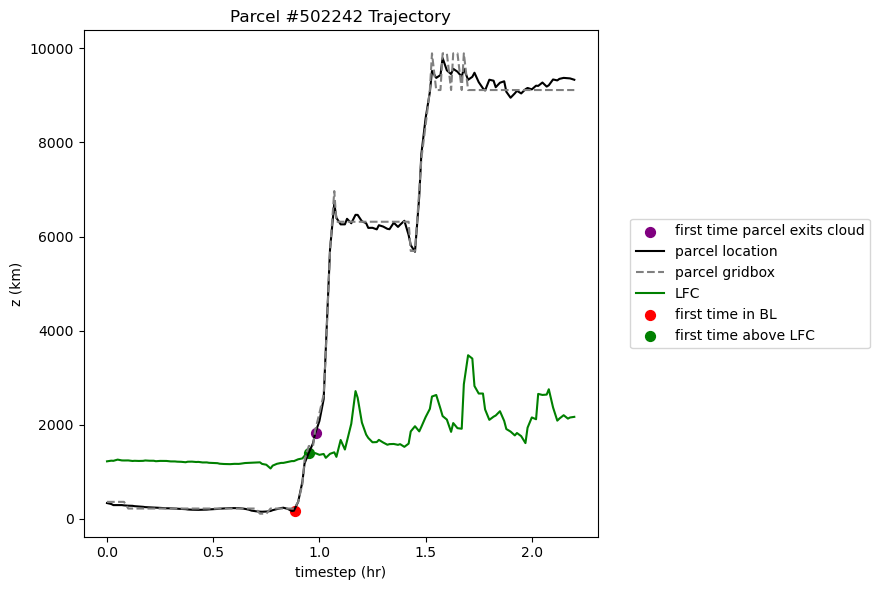

In [170]:
def TrajectoryPlot_Single(out_arr, i):
    
    # Assuming 'data', 'ALL_out_arr', 'parcel', 'LFC_data', 'Z', 'T', 'Y', 'X', etc., are already defined
    
    # Define grid for the plot and legend
    fig = plt.figure(figsize=(10, 6))
    gs = gridspec.GridSpec(1, 2, width_ratios=[0.85, 0.15])  # 1 row, 2 columns, second column is smaller for legend
    
    # Define the first subplot for the trajectory plot
    ax1 = plt.subplot(gs[0])
    
    # Define time steps and other data
    num_mins=1 #5
    tsteps = np.arange(ModelData.Ntime) * num_mins / 60
    tsteps = np.round(tsteps, 2)
    
    p = out_arr[i, 0]
    t1 = out_arr[i, 1]
    t2 = out_arr[i, 2]
    
    z1 = parcel_z[t1, p-index_adjust]
    z2 = parcel_z[t2, p-index_adjust]
    
    zs = parcel_z[:, p-index_adjust]
    zgrids = ModelData.zh[Z[:, p-index_adjust]] * 1000
    
    ts=np.arange(ModelData.Ntime)
    lfcs = LFC_data[ts, Y[:, p-index_adjust], X[:, p-index_adjust]]

    ############ #finding where parcel exits cloud
    qcqis = QCQI[:, p-index_adjust]
    qcqis_afterlfc = qcqis[t2:]
    mask = np.where(qcqis_afterlfc < 1e-6)[0]

    if mask.size > 0:
        where_cloudexit = mask[0]
        t_cloudexit = t2 + where_cloudexit
        z_cloudexit = parcel_z[t_cloudexit, p-index_adjust]
        ax1.scatter(t_cloudexit * num_mins / 60, z_cloudexit, color='purple', s=50, label='first time parcel exits cloud')
    ############ #finding where parcel exits cloud
    
    # Plot parcel trajectory, grid, and LFC
    ax1.plot(tsteps, zs, color='black', label='parcel location')
    ax1.plot(tsteps, zgrids, linestyle='dashed', color='grey', label='parcel gridbox')
    ax1.plot(tsteps, lfcs, color='green', label='LFC', zorder=-10)
    ax1.scatter(t1 * num_mins / 60, z1, color='red', s=50, label='first time in BL')
    ax1.scatter(t2 * num_mins / 60, z2, color='green', s=50, label='first time above LFC')
    
    # Labels and title
    ax1.set_xlabel('timestep (hr)')
    ax1.set_ylabel('z (km)')
    ax1.set_title(f'Parcel #{p} Trajectory')
    
    # Set up legend in the second subplot (outside of the plot)
    # Adjusting bbox_to_anchor to move legend outside
    ax1.legend(bbox_to_anchor=(1.05, 0.5), loc='center left', fontsize=10)
    
    # Adjust layout to prevent overlap
    fig.tight_layout()
    
    # Show the plot
    plt.show()

out_arr = trackedArrays_filtered["CL"]["SHALLOW"]
# i=1
# i-=1
i=21
TrajectoryPlot_Single(out_arr, i)

In [126]:
def TrajectoryPlot(out_arr, p, title, ax, ax_legend=None):
    num_mins = 1
    tsteps = np.round(np.arange(ModelData.Ntime) * num_mins / 60, 2)

    # p = out_arr[i, 0]
    # print(np.where(out_arr[:, 0]==p))
    i=np.where(out_arr[:, 0]==p)[0][0]
    t1 = out_arr[i, 1]
    t2 = out_arr[i, 2]

    z1 = parcel_z[t1, p-index_adjust]
    z2 = parcel_z[t2, p-index_adjust]

    zs = parcel_z[:, p-index_adjust]
    zgrids = ModelData.zh[Z[:, p-index_adjust]] * 1000
    ts = np.arange(ModelData.Ntime)
    lfcs = LFC_data[ts, Y[:, p-index_adjust], X[:, p-index_adjust]]

    ############ #finding where parcel exits cloud
    qcqis = QCQI[:, p-index_adjust]
    qcqis_afterlfc = qcqis[t2:]
    mask = np.where(qcqis_afterlfc < 1e-6)[0]

    if mask.size > 0:
        where_cloudexit = mask[0]
        t_cloudexit = t2 + where_cloudexit
        z_cloudexit = parcel_z[t_cloudexit, p-index_adjust]
        ax.scatter(t_cloudexit * num_mins / 60, z_cloudexit, color='purple', s=50, 
                   label='first time parcel exits cloud',zorder=10)
    ############ #finding where parcel exits cloud

    # Main plot
    ax.plot(tsteps, zs, color='black', label='parcel location')
    ax.plot(tsteps, zgrids, linestyle='dashed', color='grey', label='parcel gridbox')
    ax.plot(tsteps, lfcs, color='green', label='LFC', zorder=-10)
    ax.scatter(t1 * num_mins / 60, z1, color='red', s=50, label='first time in BL',zorder=10)
    ax.scatter(t2 * num_mins / 60, z2, color='green', s=50, label='first time above LFC',zorder=10)

    ax.set_xlabel('timestep (hr)')
    ax.set_ylabel('z (km)')
    # ax.set_title(f'{title} Parcel #{p} Trajectory')
    ax.set_title(f'{title} Trajectory (p = {p})')

    # Skip internal legend if shared
    if ax_legend is not None:
        ax_legend.axis('off')
        handles, labels = ax.get_legend_handles_labels()
        ax_legend.legend(handles, labels, loc='center', fontsize=10)


In [127]:
#FUNCTIONS FOR PLOTTING CONVERGENCE

def GetConvergence(t,z):
    timeString = ModelData.timeStrings[t]
    varName = 'convergence'
    convergence = CallVariable(ModelData, DataManager, timeString, varName)
    return convergence[z]

 #data manager class (for convergence)
DataManager_convergence = DataManager_Class(mainDirectory, scratchDirectory, ModelData.res, ModelData.t_res, ModelData.Nz_str,
                                ModelData.Np_str, dataType="Tracking_Algorithms", dataName="Eulerian_CLTracking",
                                dtype='float32',codeSection = "Project_Algorithms")
    
def LoadTrackedData(t):
    timeString = ModelData.timeStrings[t]
    Dictionary = TrackingAlgorithms_DataLoading_Class.LoadData(ModelData,DataManager_convergence, timeString)
    maxConvergence_X = Dictionary["maxConvergence_X"]
    return maxConvergence_X

import os
import pickle
import numpy as np
from tqdm import tqdm

def GetCLim():
    # Choose output pickle file path
    output_pkl = "convergence_stats.pkl"
    
    # ------------------------------------------------------------
    # If file exists → load and skip calculations
    # ------------------------------------------------------------
    if os.path.exists(output_pkl):
        with open(output_pkl, "rb") as f:
            conv_stats = pickle.load(f)
        clim = (np.min(conv_stats['min']),np.max(conv_stats['max']))
        print(f"Loaded existing convergence stats from: {output_pkl}")
    
    # ------------------------------------------------------------
    # Otherwise compute and save
    # ------------------------------------------------------------
    else:
        print("Computing convergence stats...")
    
        # Find level closest to 350 m
        zlev = int(np.abs(ModelData.zh - 350/1e3).argmin())
    
        # Initialize dictionary
        conv_stats = {"min": [], "max": []}
    
        # Loop over all timesteps
        for t in tqdm(range(ModelData.Ntime), desc="Computing convergence stats"):
            conv_z = GetConvergence(t, zlev)  # 2D field
            conv_min = np.nanmin(conv_z)
            conv_max = np.nanmax(conv_z)
            conv_stats["min"].append(conv_min)
            conv_stats["max"].append(conv_max)
    
        # Optionally store associated times
        conv_stats["time"] = getattr(ModelData, "time", None)
    
        # Convert lists to numpy arrays
        conv_stats["min"] = np.array(conv_stats["min"])
        conv_stats["max"] = np.array(conv_stats["max"])
    
        # Save to pickle
        with open(output_pkl, "wb") as f:
            pickle.dump(conv_stats, f)
    
        clim = (np.min(conv_stats['min']),np.max(conv_stats['max']))
        print(f"Saved convergence stats to: {output_pkl}")

    return clim
clim = GetCLim()

def CL_plotting(axis, t, zlev, 
                clim,
                font_size=12, index_adjust=0, ocean_fraction=2/8):

    #loading convergence data
    conv_z = GetConvergence(t, zlev)

    #plotting convergence
    if clim is not None:
        levels = np.linspace(clim[0] * 1000, clim[1] * 1000, 40)
        contour = axis.contourf(
            xh, yh, conv_z * 1000,
            levels=levels,
            # cmap="RdBu_r"
    )
    else:
        contour = axis.contourf(xh, yh, conv_z * 1000, levels=40)
    
    #CHANGE MADE HERE#
    ##################
    # cbar = plt.colorbar(contour, ax=axis, pad=0)
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    divider = make_axes_locatable(axis)
    cax = divider.append_axes("right", size="2%", pad=0.0)   # ← main change
    cbar = plt.colorbar(contour, cax=cax)
    ##################

    
    cbar.set_label(r'$-\nabla \cdot \vec{V}_H\ (s^{-1})$', fontsize=font_size)
    cbar.ax.tick_params(labelsize=font_size)
    cbar.ax.yaxis.label.set_size(font_size)

    axis.set_xlabel('x (km)', fontsize=font_size)
    axis.set_ylabel('y (km)', fontsize=font_size)
    axis.tick_params(axis='both', which='major', labelsize=font_size)

    #loading tracked CL data
    maxConvergence_X = LoadTrackedData(t)

    # Scatter max convergence points
    for yind in range(ModelData.Nyh):
        local_maxes = maxConvergence_X[zlev, yind]
        local_maxes = local_maxes[local_maxes != -1]
        local_maxes = local_maxes.astype(int)
        axis.scatter(xh[local_maxes], [yh[yind]] * len(local_maxes), color='red', s=1)


    # Coastline
    axis.axvline(x=(ModelData.Nxf) * ocean_fraction, color='black', linewidth=1.5, label='Coastline')

    # Legend
    ([days, hours, mins], _) = get_time(ModelData.time, t, (0, 6, 0))
    handle_pts = mlines.Line2D([], [], color='red', marker='o', linestyle='None', markersize=6, label='Convergence Local Y-Maxima')
    handle_time = mlines.Line2D([], [], color='none', label=f't = {t + index_adjust} = {days}:{hours}:{mins}')
    handle_z = mlines.Line2D([], [], color='none', label=f'z = {ModelData.zh[zlev]*1000:.0f} m')
    handle_c = mlines.Line2D([], [], color='black', lw=3, label='Coastline')
    legend = axis.legend(handles=[handle_pts, handle_c, handle_time, handle_z], loc='upper left', fontsize=font_size)
    for text in legend.get_texts():
        text.set_fontsize(font_size)

=== DataManager Summary ===
 inputDirectory #:   /mnt/lustre/koa/koastore/torri_group/air_directory/Projects/DCI-Project/Code/OUTPUT/Variable_Calculation/TimeSplitModelData
 outputDirectory #:   /mnt/lustre/koa/koastore/torri_group/air_directory/Projects/DCI-Project/Code/OUTPUT/Project_Algorithms/Tracking_Algorithms
 inputDataDirectory #:   /mnt/lustre/koa/koastore/torri_group/air_directory/Projects/DCI-Project/Code/OUTPUT/Variable_Calculation/TimeSplitModelData/1km_5min_34nz/ModelData
 inputParcelDirectory #:   /mnt/lustre/koa/koastore/torri_group/air_directory/Projects/DCI-Project/Code/OUTPUT/Variable_Calculation/TimeSplitModelData/1km_5min_34nz/ParcelData
 outputDataDirectory #:   /mnt/lustre/koa/koastore/torri_group/air_directory/Projects/DCI-Project/Code/OUTPUT/Project_Algorithms/Tracking_Algorithms/1km_5min_34nz/Eulerian_CLTracking

Loaded existing convergence stats from: convergence_stats.pkl


Loaded data from /mnt/lustre/koa/koastore/torri_group/air_directory/Projects/DCI-Project/Code/OUTPUT/Project_Algorithms/Tracking_Algorithms/1km_5min_34nz/Eulerian_CLTracking/Eulerian_CLTracking_1km_5min_34nz_8-20-00.h5 (2 variables)

Saving figure to /mnt/lustre/koa/koastore/torri_group/air_directory/Projects/DCI-Project/Code/PLOTTING/Project_Algorithms/Tracking_Algorithms/Tracked_Trajectories/1km_5min_34nz/ConvergenceContour_TrackedTrajectory_8-20-00_1km_5min_1e6.jpg


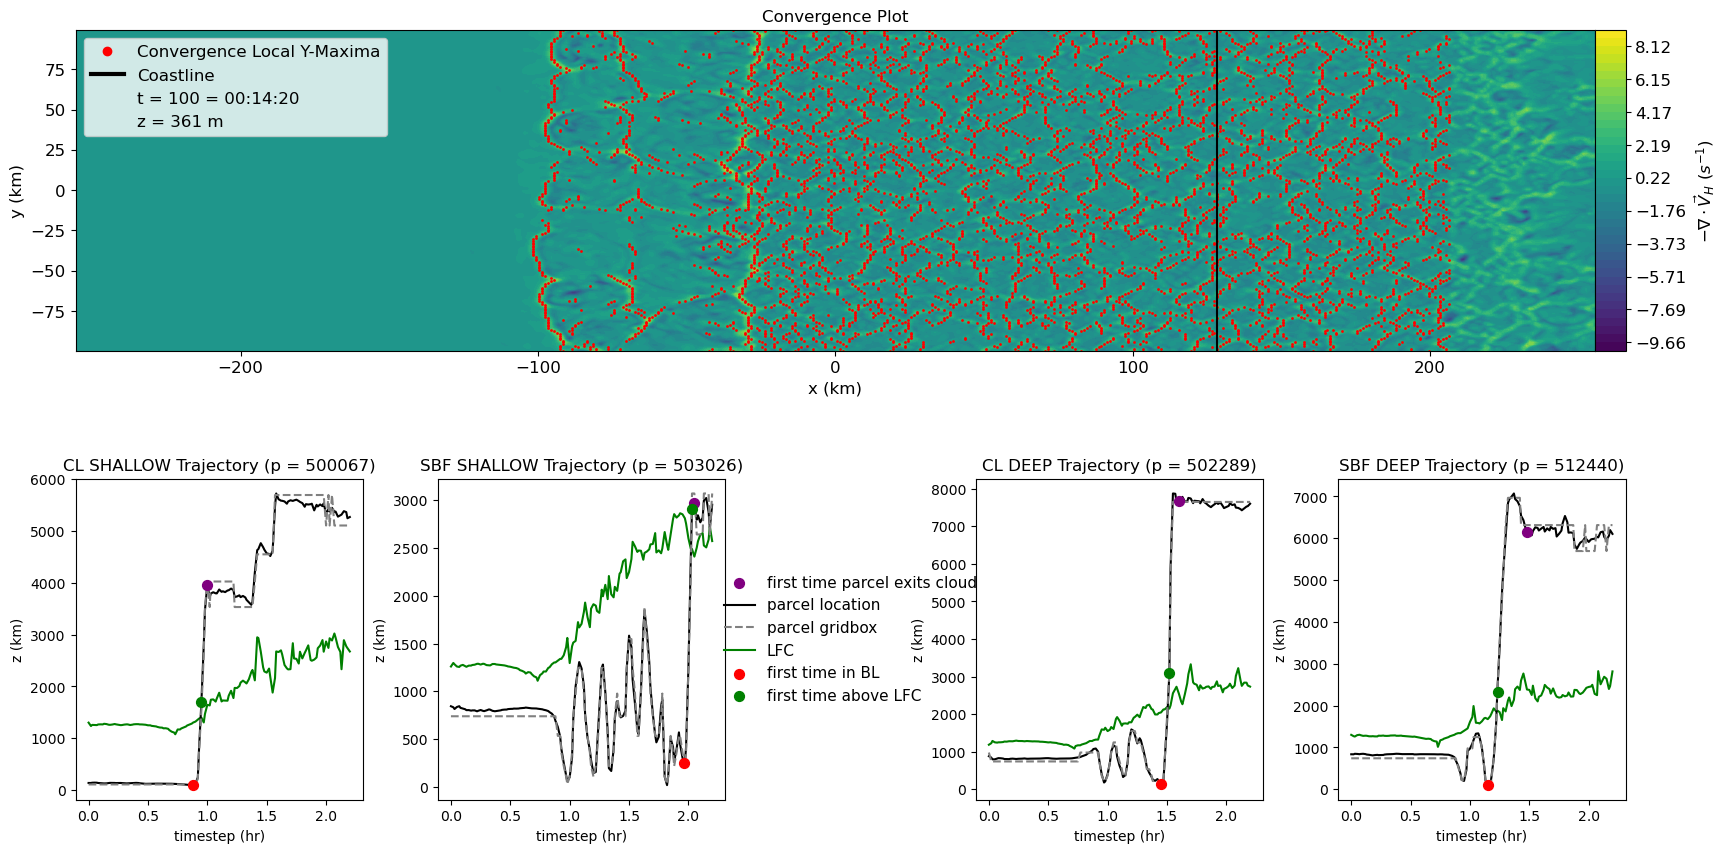

In [128]:
# Define parcel indices
if ModelData.res == "1km" and ModelData.t_res == "5min":
    indexes = [1, 3, 0, 0]
if ModelData.res == "250m":
    parcel_ids = [0, 0, 0, 0]
    
out_arrs = [trackedArrays_filtered['CL']['SHALLOW'], trackedArrays_filtered['SBF']['SHALLOW'], 
            trackedArrays_filtered['CL']['DEEP'], trackedArrays_filtered['SBF']['DEEP']]
titles = ['CL SHALLOW', 'SBF SHALLOW', 'CL DEEP', 'SBF DEEP']

parcel_ids = [ out_arrs[0][:,0][indexes[0]],out_arrs[1][:,0][indexes[1]],
              out_arrs[2][:,0][indexes[2]],out_arrs[3][:,0][indexes[3]] ] 

# Create figure with 2 rows, 3 columns
fig = plt.figure(figsize=(20, 10))
gs = gridspec.GridSpec(2, 5, hspace=0.4, wspace=0.3,
                      width_ratios=[1, 1, 0.35, 1, 1]) #column ratios

# Define axes for the 2x2 parcel plots
plot_positions = [(1, 0), (1, 1), (1, 3), (1, 4)]
axs = [plt.subplot(gs[row, col]) for row, col in plot_positions]

# Create the convergence plot axis spanning bottom row, cols 2-3
ax_convergence = plt.subplot(gs[0,:])

# Create the legend axis (top right)
ax_legend = plt.subplot(gs[1, 2])

#### CONVERGENCE PLOT
# Plot convergence in its own axis (add your plotting function here)
xh=ModelData.xh
yh=ModelData.yh
t=100; zlev = int(np.abs(ModelData.zh - 350/1e3).argmin())
CL_plotting(ax_convergence, t, zlev, clim)
ax_convergence.set_title("Convergence Plot")  # Customize as needed
####

# TRAJECTORY PLOTS
for p, ax, out_arr, title in zip(parcel_ids, axs, out_arrs, titles):
    TrajectoryPlot(out_arr, p, title, ax, ax_legend=None)


# Shared legend setup
handles, labels = axs[0].get_legend_handles_labels()
ax_legend.axis('off')
ax_legend.legend(handles, labels, loc='center', fontsize=11, frameon=False)

#SAVING PLOT
fileName=f"ConvergenceContour_TrackedTrajectory_{ModelData.timeStrings[t]}" 
SaveFigure(fig,plotType="Project_Algorithms/Tracking_Algorithms/Tracked_Trajectories",fileName=fileName)